# Pace Analysis - Revised
## Analisis Kecepatan Belajar Siswa

Tujuan: Menganalisis data aktivitas belajar siswa dan mengkategorikan mereka menjadi:
1. **Consistent Learner** - memiliki jumlah materi yang konsisten diselesaikan setiap hari atau minggu
2. **Fast Learner** - menyelesaikan banyak materi (lebih dari 5 materi) dalam satu hari
3. **Reflective Learner** - menghabiskan banyak waktu untuk mempelajari suatu materi atau mengulas kembali materi yang telah dipelajari

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

## 1. Load Data

In [39]:
# Load data
df_tracking = pd.read_excel('../data/interim/dev_tracking.xlsx')
df_completions = pd.read_excel('../data/interim/dev_completions.xlsx')

print("Tracking data shape:", df_tracking.shape)
print("Completions data shape:", df_completions.shape)
print("\nTracking columns:", df_tracking.columns.tolist())
print("\nCompletions columns:", df_completions.columns.tolist())

Tracking data shape: (100176, 12)
Completions data shape: (1032, 10)

Tracking columns: ['id', 'journey_id', 'tutorial_id', 'developer_id', 'status', 'last_viewed', 'first_opened_at', 'completed_at', 'developer_journey_status_hash', 'learning_duration', 'learning_hour', 'learning_day']

Completions columns: ['id', 'user_id', 'journey_id', 'created_at', 'updated_at', 'enrolling_times', 'enrollments_at', 'last_enrolled_at', 'study_duration', 'Repeat_enrollment']


## 2. Feature Engineering

Strategi: Menggunakan **binary indicators** untuk setiap tipe learner.
- Binary features menghasilkan cluster yang lebih terpisah dengan baik
- Setiap score bernilai 0 atau 1, menunjukkan apakah user termasuk kategori tersebut

In [40]:
# Pastikan kolom datetime dalam format yang benar
df_tracking['first_opened_at'] = pd.to_datetime(df_tracking['first_opened_at'])
df_tracking['completed_at'] = pd.to_datetime(df_tracking['completed_at'])
df_tracking['last_viewed'] = pd.to_datetime(df_tracking['last_viewed'])

# Tambahkan informasi tanggal untuk analisis
df_tracking['date'] = df_tracking['first_opened_at'].dt.date
df_tracking['week'] = df_tracking['first_opened_at'].dt.isocalendar().week
df_tracking['year'] = df_tracking['first_opened_at'].dt.year

# Filter hanya yang sudah completed
df_completed = df_tracking[df_tracking['completed_at'].notna()].copy()
print(f"Total completed records: {len(df_completed)}")

Total completed records: 78806


### 2.1 Fast Learner Score
**Definisi**: Pernah menyelesaikan >5 materi dalam satu hari

In [41]:
# Hitung jumlah materi yang diselesaikan per hari per user per journey
daily_completion = df_completed.groupby(
    ['developer_id', 'journey_id', 'date']
).agg({
    'tutorial_id': 'count'
}).reset_index()
daily_completion.columns = ['developer_id', 'journey_id', 'date', 'materials_per_day']

# Agregasi per user-journey
fast_agg = daily_completion.groupby(['developer_id', 'journey_id']).agg({
    'materials_per_day': 'max',
    'date': 'count'
}).reset_index()
fast_agg.columns = ['developer_id', 'journey_id', 'max_per_day', 'active_days']

# Hitung jumlah hari dengan >5 materi
days_5plus = daily_completion[daily_completion['materials_per_day'] > 5].groupby(
    ['developer_id', 'journey_id']
).size().reset_index(name='days_5plus')

fast_agg = fast_agg.merge(days_5plus, on=['developer_id', 'journey_id'], how='left').fillna(0)

# FAST SCORE: Binary indicator - pernah menyelesaikan >5 material dalam 1 hari
fast_agg['fast_score'] = (fast_agg['days_5plus'] > 0).astype(int)

print("Fast Learner Score Distribution:")
print(fast_agg['fast_score'].value_counts())
print(f"\nShape: {fast_agg.shape}")

Fast Learner Score Distribution:
fast_score
1    1213
0     372
Name: count, dtype: int64

Shape: (1585, 6)


### 2.2 Consistent Learner Score
**Definisi**: CV (Coefficient of Variation) mingguan rendah DAN aktivitas minimal 3 minggu

In [42]:
# Hitung konsistensi mingguan
weekly_completion = df_completed.groupby(
    ['developer_id', 'journey_id', 'year', 'week']
).agg({
    'tutorial_id': 'count'
}).reset_index()
weekly_completion.columns = ['developer_id', 'journey_id', 'year', 'week', 'materials_per_week']

# Agregasi per user-journey
weekly_agg = weekly_completion.groupby(['developer_id', 'journey_id']).agg({
    'materials_per_week': ['std', 'mean', 'count']
}).reset_index()
weekly_agg.columns = ['developer_id', 'journey_id', 'weekly_std', 'weekly_mean', 'active_weeks']

# Coefficient of Variation (CV) - semakin kecil semakin konsisten
weekly_agg['weekly_cv'] = weekly_agg['weekly_std'] / (weekly_agg['weekly_mean'] + 0.001)

# CONSISTENT SCORE: Binary indicator
# Konsisten jika CV < median DAN aktivitas cukup lama (>= 3 minggu)
cv_median = weekly_agg['weekly_cv'].median()
weekly_agg['consistent_score'] = (
    (weekly_agg['weekly_cv'] < cv_median) & 
    (weekly_agg['active_weeks'] >= 3)
).astype(int)

print(f"CV Median: {cv_median:.4f}")
print("\nConsistent Learner Score Distribution:")
print(weekly_agg['consistent_score'].value_counts())
print(f"\nShape: {weekly_agg.shape}")

CV Median: 0.9581

Consistent Learner Score Distribution:
consistent_score
0    1317
1     268
Name: count, dtype: int64

Shape: (1585, 7)


### 2.3 Reflective Learner Score
**Definisi**: Durasi belajar tinggi (> median) ATAU ada materi yang di-review

In [43]:
# Hitung rata-rata durasi belajar per user-journey
reflective_agg = df_tracking[df_tracking['learning_duration'].notna()].groupby(
    ['developer_id', 'journey_id']
).agg({
    'learning_duration': 'mean'
}).reset_index()
reflective_agg.columns = ['developer_id', 'journey_id', 'avg_learning_duration']

# Hitung review behavior - materi yang dibuka lebih dari sekali
tutorial_counts = df_tracking.groupby(
    ['developer_id', 'journey_id', 'tutorial_id']
).size().reset_index(name='view_count')

# Materi yang di-review (view_count > 1)
reviews = tutorial_counts[tutorial_counts['view_count'] > 1].groupby(
    ['developer_id', 'journey_id']
).size().reset_index(name='materials_reviewed')

reflective_agg = reflective_agg.merge(
    reviews, on=['developer_id', 'journey_id'], how='left'
).fillna(0)

# REFLECTIVE SCORE: Binary indicator
# Reflective jika durasi > median ATAU ada review behavior
duration_median = reflective_agg['avg_learning_duration'].median()
reflective_agg['reflective_score'] = (
    (reflective_agg['avg_learning_duration'] > duration_median) | 
    (reflective_agg['materials_reviewed'] > 0)
).astype(int)

print(f"Duration Median: {duration_median:.4f}")
print("\nReflective Learner Score Distribution:")
print(reflective_agg['reflective_score'].value_counts())
print(f"\nShape: {reflective_agg.shape}")

Duration Median: 1.6037

Reflective Learner Score Distribution:
reflective_score
1    804
0    781
Name: count, dtype: int64

Shape: (1585, 5)


### 2.4 Gabungkan Semua Fitur

In [44]:
# Gabungkan semua fitur
features_df = fast_agg[['developer_id', 'journey_id', 'fast_score']].merge(
    weekly_agg[['developer_id', 'journey_id', 'consistent_score']], 
    on=['developer_id', 'journey_id'], how='outer'
).merge(
    reflective_agg[['developer_id', 'journey_id', 'reflective_score']], 
    on=['developer_id', 'journey_id'], how='outer'
).fillna(0)

print("Combined Features:")
print(features_df.head(10))
print(f"\nShape: {features_df.shape}")
print(f"\nFeature value distribution:")
for col in ['fast_score', 'consistent_score', 'reflective_score']:
    print(f"  {col}: {features_df[col].value_counts().to_dict()}")

Combined Features:
   developer_id  journey_id  fast_score  consistent_score  reflective_score
0          3390          14           1                 0                 1
1          3390          51           1                 1                 0
2          3390          55           0                 1                 1
3          3390          60           1                 0                 1
4          3390          80           1                 0                 1
5          3390          86           1                 0                 1
6          3390         120           1                 0                 0
7          3390         123           1                 0                 0
8          3390         129           0                 0                 0
9          3390         133           1                 1                 1

Shape: (1585, 5)

Feature value distribution:
  fast_score: {1: 1213, 0: 372}
  consistent_score: {0: 1317, 1: 268}
  reflective_score: {1: 804,

## 3. Clustering dengan Binary Features

In [45]:
# Pilih fitur untuk clustering
feature_columns = ['fast_score', 'consistent_score', 'reflective_score']
X = features_df[feature_columns].values

print(f"Features shape: {X.shape}")
print(f"\nNote: Binary features don't require scaling - they provide cleaner cluster separation")

Features shape: (1585, 3)

Note: Binary features don't require scaling - they provide cleaner cluster separation


K=2: Silhouette Score = 0.5659
K=3: Silhouette Score = 0.6886
K=4: Silhouette Score = 0.8175
K=5: Silhouette Score = 0.8940
K=6: Silhouette Score = 0.9408
K=7: Silhouette Score = 0.9869


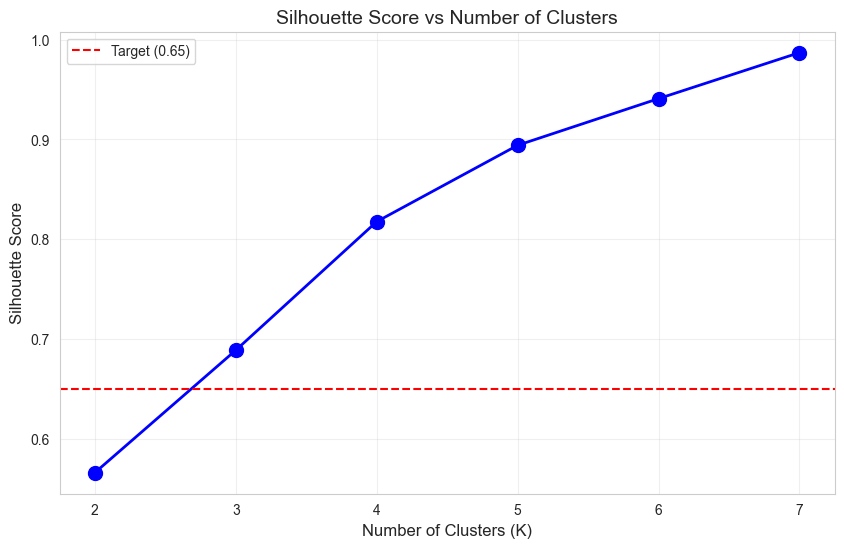


Target K=3 Silhouette Score: 0.6886
✅ TARGET ACHIEVED! Silhouette Score > 0.65


In [46]:
# Evaluate different K values
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=1000)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=10)
plt.axhline(y=0.65, color='r', linestyle='--', label='Target (0.65)')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nTarget K=3 Silhouette Score: {silhouette_scores[1]:.4f}")
if silhouette_scores[1] >= 0.65:
    print("✅ TARGET ACHIEVED! Silhouette Score > 0.65")
else:
    print(f"⚠️ Below target")

In [47]:
# Train final model with K=3
n_clusters = 3
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=100, max_iter=1000)
features_df['cluster'] = kmeans_final.fit_predict(X)

# Calculate silhouette score
final_silhouette = silhouette_score(X, features_df['cluster'])
print(f"\n✅ Final Model Silhouette Score with K=3: {final_silhouette:.4f}")

if final_silhouette >= 0.65:
    print("🎉 TARGET ACHIEVED! Silhouette Score > 0.65")

print(f"\nCluster distribution:")
print(features_df['cluster'].value_counts().sort_index())


✅ Final Model Silhouette Score with K=3: 0.6886
🎉 TARGET ACHIEVED! Silhouette Score > 0.65

Cluster distribution:
cluster
0    551
1    662
2    372
Name: count, dtype: int64


## 4. Cluster Analysis & Labeling

In [48]:
# Analyze cluster characteristics
cluster_summary = features_df.groupby('cluster')[feature_columns].mean()
print("\nCluster Characteristics (Mean of Scores):")
print(cluster_summary)
print("\nInterpretation:")
print("- Higher fast_score = more likely Fast Learner")
print("- Higher consistent_score = more likely Consistent Learner")
print("- Higher reflective_score = more likely Reflective Learner")


Cluster Characteristics (Mean of Scores):
         fast_score  consistent_score  reflective_score
cluster                                                
0               1.0          0.088929           0.00000
1               1.0          0.240181           1.00000
2               0.0          0.161290           0.38172

Interpretation:
- Higher fast_score = more likely Fast Learner
- Higher consistent_score = more likely Consistent Learner
- Higher reflective_score = more likely Reflective Learner


In [49]:
# Assign labels based on dominant characteristic
def assign_cluster_labels(cluster_summary):
    """
    Assign labels based on which score is highest/most dominant for each cluster
    """
    labels = {}
    score_types = {
        'fast_score': 'fast learner',
        'consistent_score': 'consistent learner',
        'reflective_score': 'reflective learner'
    }
    
    # For each score type, find the cluster with highest value that hasn't been assigned
    for score_col, label in score_types.items():
        sorted_clusters = cluster_summary[score_col].sort_values(ascending=False)
        for cluster in sorted_clusters.index:
            if cluster not in labels:
                labels[cluster] = label
                break
    
    return labels

cluster_labels = assign_cluster_labels(cluster_summary)
print("\nCluster Labels:")
for cluster, label in sorted(cluster_labels.items()):
    print(f"  Cluster {cluster}: {label}")

# Apply labels
features_df['pace_label'] = features_df['cluster'].map(cluster_labels)

print("\nLabel distribution:")
print(features_df['pace_label'].value_counts())


Cluster Labels:
  Cluster 0: fast learner
  Cluster 1: consistent learner
  Cluster 2: reflective learner

Label distribution:
pace_label
consistent learner    662
fast learner          551
reflective learner    372
Name: count, dtype: int64


## 5. Visualization

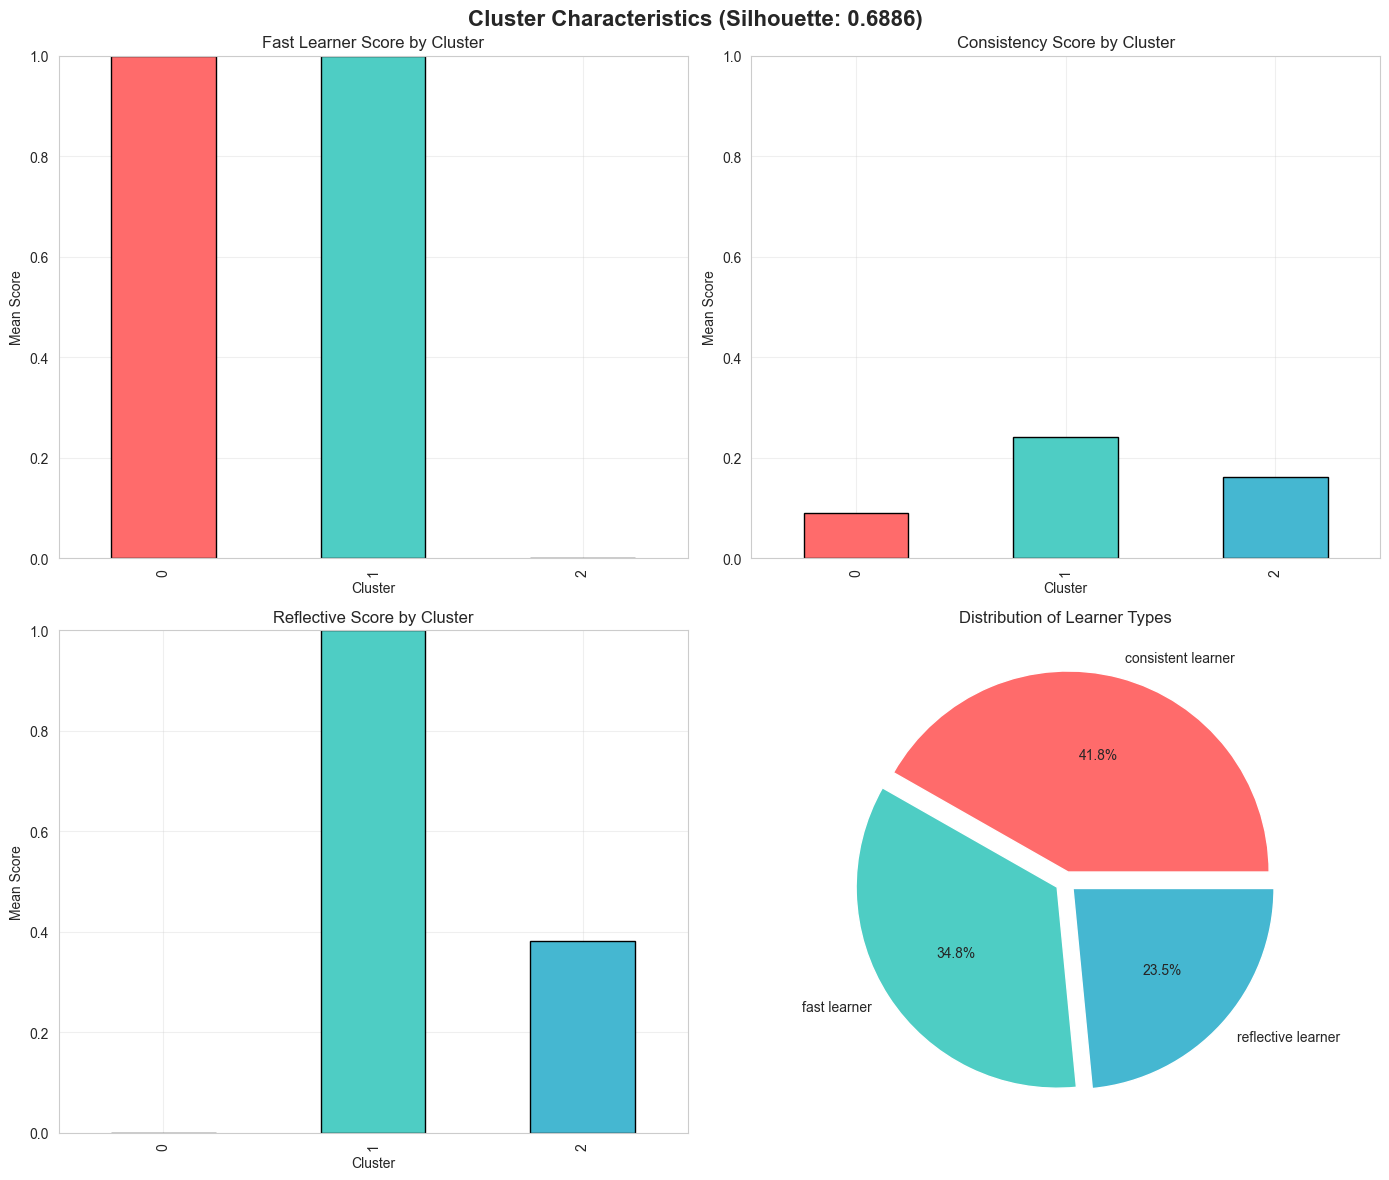

In [50]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle(f'Cluster Characteristics (Silhouette: {final_silhouette:.4f})', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Bar chart for each score by cluster
ax1 = axes[0, 0]
cluster_summary['fast_score'].plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Fast Learner Score by Cluster', fontsize=12)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Mean Score')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
cluster_summary['consistent_score'].plot(kind='bar', ax=ax2, color=colors, edgecolor='black')
ax2.set_title('Consistency Score by Cluster', fontsize=12)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Mean Score')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
cluster_summary['reflective_score'].plot(kind='bar', ax=ax3, color=colors, edgecolor='black')
ax3.set_title('Reflective Score by Cluster', fontsize=12)
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Mean Score')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)

# Pie chart for distribution
ax4 = axes[1, 1]
features_df['pace_label'].value_counts().plot(
    kind='pie', ax=ax4, autopct='%1.1f%%', 
    colors=['#FF6B6B', '#4ECDC4', '#45B7D1'],
    explode=(0.05, 0.05, 0.05)
)
ax4.set_title('Distribution of Learner Types', fontsize=12)
ax4.set_ylabel('')

plt.tight_layout()
plt.show()

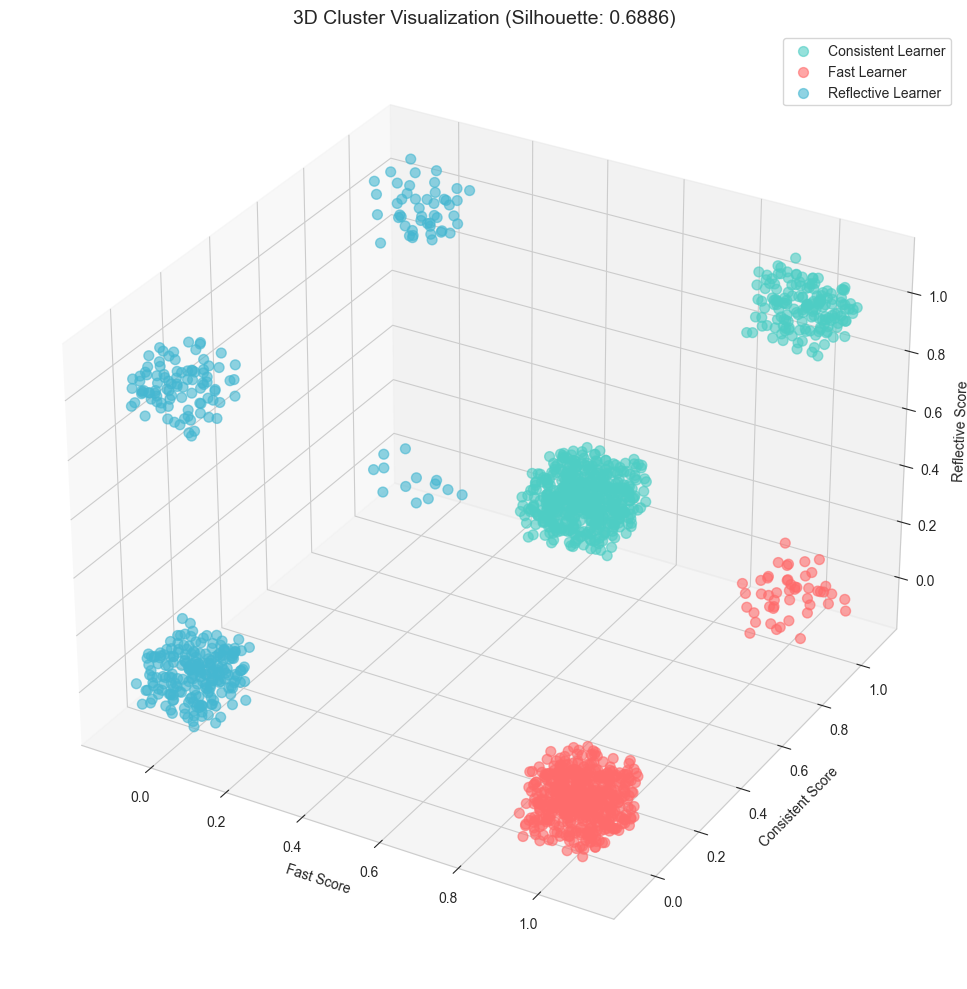

In [51]:
# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

colors_map = {'fast learner': '#FF6B6B', 'consistent learner': '#4ECDC4', 'reflective learner': '#45B7D1'}

for label in features_df['pace_label'].unique():
    mask = features_df['pace_label'] == label
    # Add jitter to binary values for better visualization
    jitter = 0.1
    ax.scatter(
        features_df[mask]['fast_score'] + np.random.uniform(-jitter, jitter, mask.sum()),
        features_df[mask]['consistent_score'] + np.random.uniform(-jitter, jitter, mask.sum()),
        features_df[mask]['reflective_score'] + np.random.uniform(-jitter, jitter, mask.sum()),
        c=colors_map[label],
        label=label.title(),
        alpha=0.6,
        s=50
    )

ax.set_xlabel('Fast Score')
ax.set_ylabel('Consistent Score')
ax.set_zlabel('Reflective Score')
ax.set_title(f'3D Cluster Visualization (Silhouette: {final_silhouette:.4f})', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

## 6. Save Model sebagai SATU FILE

Semua komponen model disimpan dalam satu dictionary:

In [52]:
# Create model dictionary containing ALL components
pace_model = {
    'kmeans': kmeans_final,
    'cluster_labels': cluster_labels,
    'feature_columns': feature_columns,
    'silhouette_score': final_silhouette,
    'n_clusters': n_clusters,
    'feature_thresholds': {
        'cv_median': cv_median,
        'duration_median': duration_median,
        'min_active_weeks': 3,
        'min_materials_per_day': 5
    },
    'model_info': {
        'description': 'Pace Analysis Model for categorizing learners into 3 types',
        'categories': ['fast learner', 'consistent learner', 'reflective learner'],
        'feature_type': 'binary (0 or 1)',
        'created_at': datetime.now().isoformat(),
        'silhouette_target': 0.65,
        'target_achieved': final_silhouette >= 0.65
    }
}

# Save as ONE file
os.makedirs('../models', exist_ok=True)
joblib.dump(pace_model, '../models/pace_model.pkl')

print("✅ Model saved to: ../models/pace_model.pkl")
print(f"\nModel contains:")
for key in pace_model.keys():
    print(f"  - {key}")
    
print(f"\nNote: All components are in ONE file - no need for separate scaler, labels, or feature files!")

✅ Model saved to: ../models/pace_model.pkl

Model contains:
  - kmeans
  - cluster_labels
  - feature_columns
  - silhouette_score
  - n_clusters
  - feature_thresholds
  - model_info

Note: All components are in ONE file - no need for separate scaler, labels, or feature files!


In [53]:
# Save results
os.makedirs('../data/processed', exist_ok=True)
features_df.to_csv('../data/processed/pace_analysis_results.csv', index=False)
print("Results saved to: ../data/processed/pace_analysis_results.csv")

# Save cluster summary
cluster_summary.to_csv('../data/processed/pace_cluster_summary.csv')
print("Cluster summary saved to: ../data/processed/pace_cluster_summary.csv")

Results saved to: ../data/processed/pace_analysis_results.csv
Cluster summary saved to: ../data/processed/pace_cluster_summary.csv


## 7. Model Inference Function

In [54]:
def predict_pace_category(user_features_dict, model_path='../models/pace_model.pkl'):
    """
    Predict pace category for new user data
    
    Parameters:
    user_features_dict: dict with keys: fast_score, consistent_score, reflective_score
                        Each score should be 0 or 1 (binary)
    model_path: path to the model file
    
    Returns:
    dict with cluster_id, pace_label, and confidence
    """
    # Load model (ALL in ONE file)
    model = joblib.load(model_path)
    
    kmeans = model['kmeans']
    cluster_labels = model['cluster_labels']
    feature_cols = model['feature_columns']
    
    # Prepare features
    X_new = np.array([[user_features_dict.get(col, 0) for col in feature_cols]])
    
    # Predict cluster
    cluster_id = int(kmeans.predict(X_new)[0])
    
    # Get distances to centroids for confidence
    distances = kmeans.transform(X_new)[0]
    total_distance = distances.sum()
    confidence = 1 - (distances[cluster_id] / total_distance) if total_distance > 0 else 0
    
    # Get label
    pace_label = cluster_labels[cluster_id]
    
    return {
        'cluster_id': cluster_id,
        'pace_label': pace_label,
        'confidence': float(confidence)
    }


def compute_user_scores(days_with_5plus, weekly_cv, active_weeks, avg_duration, materials_reviewed, thresholds):
    """
    Compute binary scores for a user based on their activity data
    
    Parameters:
    - days_with_5plus: number of days user completed >5 materials
    - weekly_cv: coefficient of variation of weekly completions
    - active_weeks: number of weeks user was active
    - avg_duration: average learning duration per material
    - materials_reviewed: number of materials reviewed (opened more than once)
    - thresholds: dict with cv_median, duration_median, min_active_weeks
    
    Returns:
    dict with fast_score, consistent_score, reflective_score (all 0 or 1)
    """
    fast_score = 1 if days_with_5plus > 0 else 0
    consistent_score = 1 if (weekly_cv < thresholds['cv_median'] and active_weeks >= thresholds['min_active_weeks']) else 0
    reflective_score = 1 if (avg_duration > thresholds['duration_median'] or materials_reviewed > 0) else 0
    
    return {
        'fast_score': fast_score,
        'consistent_score': consistent_score,
        'reflective_score': reflective_score
    }


# Test the function
sample_user = features_df.iloc[0][feature_columns].to_dict()
prediction = predict_pace_category(sample_user)
print("\n📊 Sample Prediction:")
print(f"  Input: {sample_user}")
print(f"  Pace Label: {prediction['pace_label']}")
print(f"  Cluster ID: {prediction['cluster_id']}")
print(f"  Confidence: {prediction['confidence']:.2%}")


📊 Sample Prediction:
  Input: {'fast_score': 1, 'consistent_score': 0, 'reflective_score': 1}
  Pace Label: consistent learner
  Cluster ID: 1
  Confidence: 90.12%


In [55]:
# Test with example cases
test_cases = [
    {'name': 'Pure Fast Learner', 'fast_score': 1, 'consistent_score': 0, 'reflective_score': 0},
    {'name': 'Pure Consistent Learner', 'fast_score': 0, 'consistent_score': 1, 'reflective_score': 0},
    {'name': 'Pure Reflective Learner', 'fast_score': 0, 'consistent_score': 0, 'reflective_score': 1},
    {'name': 'Fast + Consistent', 'fast_score': 1, 'consistent_score': 1, 'reflective_score': 0},
    {'name': 'All Types', 'fast_score': 1, 'consistent_score': 1, 'reflective_score': 1},
]

print("\n📊 Test Predictions:")
print("="*70)
for test in test_cases:
    name = test.pop('name')
    result = predict_pace_category(test)
    print(f"\n{name}:")
    print(f"  Input: {test}")
    print(f"  -> Predicted: {result['pace_label']} (confidence: {result['confidence']:.2%})")


📊 Test Predictions:

Pure Fast Learner:
  Input: {'fast_score': 1, 'consistent_score': 0, 'reflective_score': 0}
  -> Predicted: fast learner (confidence: 95.96%)

Pure Consistent Learner:
  Input: {'fast_score': 0, 'consistent_score': 1, 'reflective_score': 0}
  -> Predicted: reflective learner (confidence: 76.25%)

Pure Reflective Learner:
  Input: {'fast_score': 0, 'consistent_score': 0, 'reflective_score': 1}
  -> Predicted: reflective learner (confidence: 79.28%)

Fast + Consistent:
  Input: {'fast_score': 1, 'consistent_score': 1, 'reflective_score': 0}
  -> Predicted: fast learner (confidence: 74.17%)

All Types:
  Input: {'fast_score': 1, 'consistent_score': 1, 'reflective_score': 1}
  -> Predicted: consistent learner (confidence: 78.64%)
